# AUTOMATED SPEECH RECOGNITION MODEL


## Modèle facebook/wav2vec2-large-xlsr-53-french

Un modèle populaire pour la reconnaissance vocale en français est facebook/wav2vec2-large-xlsr-53-french. Ce modèle est basé sur la technologie Wav2Vec 2.0, qui a montré de bonnes performances pour diverses langues, y compris le français

In [86]:
from transformers import Wav2Vec2ForCTC, Wav2Vec2Tokenizer
import torch
import torchaudio

In [ ]:
# Load the model and the Tokenizer
tokenizer = Wav2Vec2Tokenizer.from_pretrained("facebook/wav2vec2-large-xlsr-53-french")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-large-xlsr-53-french")

# Assurez-vous que le modèle est en mode d'inférence
model.eval()

### Audio pre-processing

In [100]:
def load_audio(file_path):
    speech, sample_rate = torchaudio.load(file_path)
    resampler = torchaudio.transforms.Resample(sample_rate, 16000)
    speech = resampler(speech).squeeze()
    return speech

audio = load_audio("/kaggle/input/asr-files/11.mp3")

In [101]:
from IPython.display import Audio, display

display(Audio('/kaggle/input/asr-files/11.mp3', autoplay = True))

### Get The transcription

In [104]:
# Tokenize the audio file
input_values = tokenizer(audio, return_tensors="pt").input_values

# Pass the datat on model
with torch.no_grad():
    logits = model(input_values).logits

# Deocde to text
predicted_ids = torch.argmax(logits, dim=-1)
transcription = tokenizer.batch_decode(predicted_ids)[0]

print(transcription) # The text to classify whether positive or Negative

ça va mal


### Evaluating the quality of an Automatic Speech Recognition (ASR) 

**Word Error Rate (WER)**  is the most widely used metric for evaluating ASR models. It measures the percentage of the  that are incorrectly predicted. It considers insertions, deletions, and substitutions.

**Character Error Rate (CER)**

CER is similar to WER but operates at the character level instead of the word level. It is useful when evaluating languages with a large vocabulary or when dealing with short transcriptions.

In [102]:
# # We use CER as we are dealing with the short transcription
# from jiwer import wer

# reference = "ça va mal"
# hypothesis = transcription
# error = cer(reference, hypothesis)
# print(f"Word Error Rate: {error}")

In [98]:
import os

# Répertoire contenant les fichiers audio
audio_dir = '/kaggle/input/asr-files/'
text = []
# Parcourir chaque fichier audio
for file_name in os.listdir(audio_dir):
    if file_name.endswith(".mp3"):
        # Charger l'audio
        audio_path = os.path.join(audio_dir, file_name)
        audio = load_audio(audio_path)

        # Transcrire l'audio
        input_values = tokenizer(audio, return_tensors="pt").input_values
        with torch.no_grad():
            logits = model(input_values).logits
        predicted_ids = torch.argmax(logits, dim=-1)
        transcription = tokenizer.batch_decode(predicted_ids)[0]
        text.append(transcription)
        # Afficher ou enregistrer la transcription
        print(f"Transcription {file_name}: {transcription}")

Transcription 3.mp3: comme ci comme ça
Transcription 12.mp3: comment sava
Transcription 16.mp3: une chaussette papa noël pere noël un bonhomme de neige une étoile ue bougie un rouge gorge un arbre de noël le hou une cloche un craîneau un cadeau une lettre une carte de noël une cheminée un joue un reine un flocon de neige
Transcription 7.mp3: je joue au foutebol je joue bien au fouttebol je nage je nage bien je danse je chante je lis
Transcription 13.mp3: s'il vous plaît
Transcription 1.mp3: oyeux anniversaires mon anniversaire est en octobre
Transcription 2.mp3: bonne nuit
Transcription 11.mp3: ça va mal


### Precision, Recall and F1 score for ASR Model

In [97]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming we have a list of keywords present in both reference and hypothesis
true_keywords = ["comme ci comme ça", "comment ça va", "une chaussette papa noël père noël un bonhomme de neige une étoile une bougie un rouge-gorge un arbre de noëlle cloux une cloche un craîneau un cadeau une lettre une carte de noël une cheminée un joue un reine un flocon de neige",
                "je joue au footeball je joue bien au football je nage je nage bien je danse je chante je lis", "s'il vous plaît", 
                "joyeux anniversaires mon anniversaire est en octobre", "bonne nuit", "ça va mal"]

predicted_keywords = text # Take the transcripted list above

precision = precision_score(true_keywords, predicted_keywords, average='micro')
recall = recall_score(true_keywords, predicted_keywords, average='micro')
f1 = f1_score(true_keywords, predicted_keywords, average='micro')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")


Precision: 0.5
Recall: 0.5
F1-Score: 0.5


# MODEL 1 LSTM BIDIRECTIONAL FOR SENTIMENT ANALYSIS

In [55]:
#Import useful libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf # For building Neural Network
import tensorflow.keras as keras # For NN
import tensorflow.keras.layers as layers # For NN
import seaborn as sns # For data vizualisation
import os

In [56]:
# Input data files are available in the read-only "../input/" directory

import os # accessing directory structure
dataset = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        dataset.append(os.path.join(dirname, filename))
        print(os.path.join(dirname, filename))

/kaggle/input/allocine-french-movie-reviews/valid.csv
/kaggle/input/allocine-french-movie-reviews/train.csv
/kaggle/input/allocine-french-movie-reviews/test.csv
/kaggle/input/asr-files/3.mp3
/kaggle/input/asr-files/12.mp3
/kaggle/input/asr-files/16.mp3
/kaggle/input/asr-files/7.mp3
/kaggle/input/asr-files/13.mp3
/kaggle/input/asr-files/1.mp3
/kaggle/input/asr-files/2.mp3
/kaggle/input/asr-files/11.mp3


### Import data

In [57]:
train_df = pd.read_csv('/kaggle/input/allocine-french-movie-reviews/train.csv').drop('Unnamed: 0', axis=1)
valid_df = pd.read_csv('/kaggle/input/allocine-french-movie-reviews/valid.csv').drop('Unnamed: 0', axis=1)
test_df = pd.read_csv('/kaggle/input/allocine-french-movie-reviews/test.csv').drop('Unnamed: 0', axis=1)

In [18]:
train_df.shape

(160000, 3)

### Check the Nan values

In [59]:

null_cols = [col for col in train_df.columns if train_df[col].isnull().sum() > 0]
print("Columns contenant des valeurs nulles", null_cols)

Columns contenant des valeurs nulles []


<Axes: xlabel='polarity', ylabel='count'>

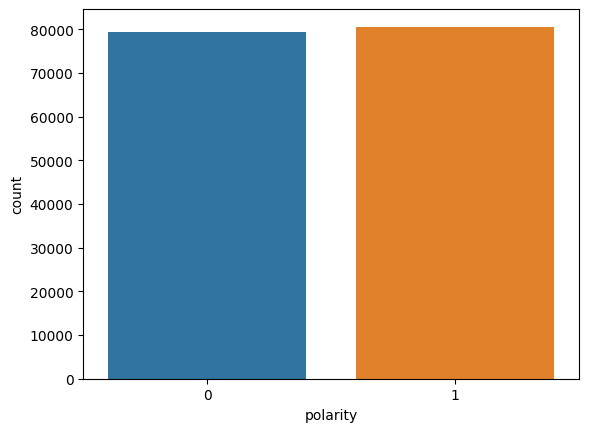

In [60]:
sns.countplot(data=train_df, x='polarity')

### Data PreparationData

In [63]:
BATCH_SIZE = 8
# Regroupe les données en lots de taille
# Met en cache les données pour accélérer les itérations futures.
# Mélange aléatoirement les données avec une taille de tampon de 1000, ce qui aide à éviter le surapprentissage (overfitting).
# Précharge les données en parallèle pour améliorer la performance.


X_train, y_train = train_df['review'], train_df['polarity']
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))\
             .batch(BATCH_SIZE)\
             .cache()\
             .shuffle(1000)\
             .prefetch(tf.data.AUTOTUNE)  #Précharge les données en parallèle pour améliorer la performance.


In [64]:
X_test, y_test = test_df['review'], test_df['polarity']
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))\
             .batch(BATCH_SIZE)\
             .cache()\
             .prefetch(tf.data.AUTOTUNE)

In [65]:
X_valid, y_valid = valid_df['review'], valid_df['polarity']
valid_ds = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))\
             .batch(BATCH_SIZE)\
             .cache()\
             .prefetch(tf.data.AUTOTUNE)

### Encoder the test

In [66]:
# Text encoder
VOCAB_SIZE = 10000
encoder = layers.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(train_ds.map(lambda text, label: text))

In [69]:
encoded_example = encoder("Bonjour, c'est un test. Merci!").numpy()
encoded_example

array([4147,   31,    6,    1,  632])

### Model creation

In [72]:

# Fit model
history = model.fit(train_ds, epochs=epochs, validation_data=valid_ds)

Epoch 1/5
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 599s 30ms/step - accuracy: 0.8378 - loss: 0.3449 - val_accuracy: 0.9212 - val_loss: 0.1983
Epoch 2/5
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 570s 28ms/step - accuracy: 0.9284 - loss: 0.1821 - val_accuracy: 0.9225 - val_loss: 0.1945
Epoch 3/5
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 580s 29ms/step - accuracy: 0.9379 - loss: 0.1586 - val_accuracy: 0.9279 - val_loss: 0.1844
Epoch 4/5
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 585s 29ms/step - accuracy: 0.9466 - loss: 0.1393 - val_accuracy: 0.9290 - val_loss: 0.1780
Epoch 5/5
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 587s 29ms/step - accuracy: 0.9541 - loss: 0.1227 - val_accuracy: 0.9348 - val_loss: 0.1783


In [77]:
model.save('kaggle/input/model_lstm_sa.h5')

In [78]:
# Evaluation
eval_res = model.evaluate(test_ds)
print("Evaluation", eval_res)

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 32s 13ms/step - accuracy: 0.9399 - loss: 0.1696
Evaluation [0.17351652681827545, 0.9378499984741211]


In [81]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

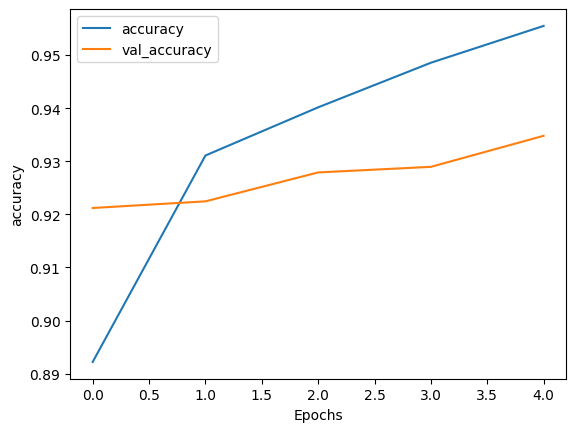

In [82]:
# Accuracy plot
plot_graphs(history,  'accuracy')

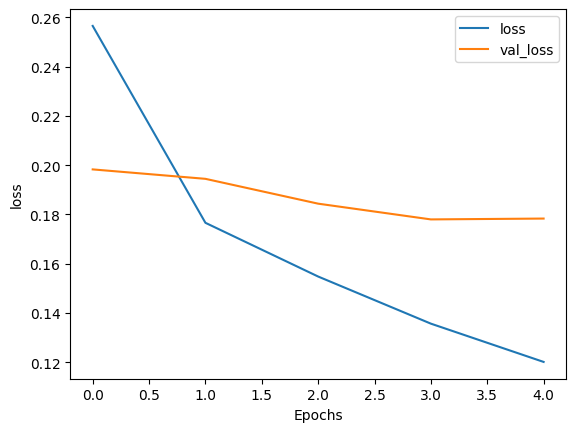

In [83]:
# Loss plot
plot_graphs(history,  'loss')

In [44]:
# Enregistrement du model
model.save('/kaggle/model/Bert_LSTM_allocine.h5')

In [ ]:
zip -r  saved_models.zip saved_model/*

# MODEL 2 SENTIMENT ANALYSIS USING BERT BIDIRICTIONEL

In [47]:

import torch
import numpy as np
import pandas as pd
import torch.nn as nn
from torch.utils.data import Dataset
from transformers import AutoTokenizer, BertModel
from sklearn.model_selection import train_test_split
#from tensorflow.keras.optimizers import Adam
#from keras.optimizers import Adam
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch import optim
from torch.optim import Adam

In [49]:
class IMDBDataset(Dataset):
    def __init__(self, device, csv_file, name_or_model_path = "bert-base-uncased", max_length=250):

        self.device = device
        self.df = pd.read_csv(csv_file)
        self.labels = self.df.polarity.unique()
        # labels_dict = dict()
        # for idx, l in enumerate(self.labels):
        #     labels_dict[l] = idx

        # self.df["toxic"] = self.df["toxic"].map(labels_dict)
        self.max_length = max_length
        self.tokenizer = AutoTokenizer.from_pretrained(name_or_model_path)


    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        review_text = self.df.review[idx]
        label_review = self.df.polarity[idx]

        inputs = self.tokenizer(review_text, padding = "max_length", max_length = self.max_length,
        truncation = True,  return_tensors = "pt",
        )
        labels = torch.tensor(label_review)

        return{
            "inputs": inputs["input_ids"].squeeze(0).to(self.device),
            "attention_mask": inputs["attention_mask"].squeeze(0).to(self.device),
            "Labels": labels.to(self.device)
        }

In [50]:
class CustomerBert(nn.Module):

    def __init__(self, name_or_model_path = "bert-base-uncased", n_classes = 2): # model du bert a choisir
        super(CustomerBert, self).__init__()
        self.bert_pretrained = BertModel.from_pretrained(name_or_model_path)
        self.classifier = nn.Linear(self.bert_pretrained.config.hidden_size, n_classes) # ca va nous permettre de prendre la sorite du model
                                        # on fait une projection lineaire et faire la classification binaire

    def forward(self, input_ids, attention_mask):
        x = self.bert_pretrained(input_ids = input_ids, attention_mask = attention_mask)
        x = self.classifier(x.pooler_output)

        return x

    def save_checkpoint(self, path):
        torch.save(self.state_dict(), path)


In [51]:

def training_step(model, data_loader, loss_fn, optimizer):
    model.train()

    total_loss = 0
    for data in tqdm(data_loader, total=len(data_loader)):
        input_ids = data["inputs"]
        attention_mask = data["attention_mask"]
        labels = data["Labels"]

        optimizer.zero_grad()

        output = model(input_ids=input_ids, attention_mask = attention_mask)
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()


    return total_loss / len(data_loader.dataset)


In [52]:
def evaluation(model, test_dataloader, loss_fn):
    model.eval()

    correct_predictions = 0
    losses = []

    for data in tqdm(test_dataloader, total=len(test_dataloader)):

        input_ids = data["inputs"]
        attention_mask = data["attention_mask"]
        labels = data["Labels"]

        output = model(input_ids=input_ids, attention_mask = attention_mask)
        _, pred = output.max(1)

        correct_predictions += torch.sum(pred == labels)
        loss = loss_fn(output, labels)
        losses.append(loss.item())

    return np.mean(losses), correct_predictions / len(test_dataloader.dataset)


In [8]:
def main():
    print("Training...")

    N_EPOCHS = 2
    LR = 2e-5
    BATCH_SIZE = 32
    train_path = '/kaggle/input/allocine-french-movie-reviews/train.csv'
    test_path = '/kaggle/input/allocine-french-movie-reviews/test.csv'

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_dataset = IMDBDataset(csv_file = train_path, device = device, max_length = 100)
    test_dataset = IMDBDataset(csv_file = test_path, device = device, max_length = 100)

    train_dataloader = DataLoader(dataset = train_dataset, batch_size= BATCH_SIZE)
    test_dataloader = DataLoader(dataset = test_dataset, batch_size= BATCH_SIZE)

    model = CustomerBert()
    model = model.to(device)

    loss_fn = nn.CrossEntropyLoss()

    #optimizer = optim.SGD(model.parameters(), lr=LR)
    #optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    optimizer = Adam(model.parameters(), lr=LR)

    for epoch in range(N_EPOCHS):
        loss_train = training_step(model, train_dataloader, loss_fn, optimizer)
        loss_eval, accuracy = evaluation(model, test_dataloader, loss_fn)

        print(f"Train Loss :{loss_train} | Eval loss: {loss_eval} | Accurary: {accuracy}")

    #save the model
    torch.save(model.state_dict(), "my_custom_bert.pth")


if __name__ == "__main__":
    main()

Training...


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use 

Train Loss :0.009160421665245668 | Eval loss: 0.22798220979571343 | Accurary: 0.9012999534606934


100%|██████████| 625/625 [02:06<00:00,  4.94it/s]


Train Loss :0.00621768284564605 | Eval loss: 0.23239789215922355 | Accurary: 0.9073999524116516


## MAKE INFERENCE OF WITH SENTIMENT ANALYSIS MODEL

In [103]:
import torch
from transformers import AutoTokenizer


# Tokenization, truncate and pad the text

def preprocess_text(text, tokenizer, max_length=100):
    inputs = tokenizer(text, padding='max_length', max_length=max_length, truncation=True, return_tensors='pt')
    return inputs

def load_model(model_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = CustomerBert()
    model.load_state_dict(torch.load(model_path))
    model = model.to(device)
    model.eval()
    return model, device

def predict(model, device, tokenizer, text):
    inputs = preprocess_text(text, tokenizer)
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    with torch.no_grad():
        output = model(input_ids=input_ids, attention_mask=attention_mask)
        _, predicted_class = output.max(1)
        # Map prediction to class labels
        label = "positive" if predicted_class.item() == 1 else "negative"
    
    return label

def main():
    model_path = "/kaggle/working/my_custom_bert.pth"
    tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")  # Use the same tokenizer as used for training
    model, device = load_model(model_path)
    
    # We give the transcription as a text to predict
    text = transcription
    predicted_class = predict(model, device, tokenizer, text)
    print(f"Transcription: {transcription}")
    print(f"Predicted class: {predicted_class}")

if __name__ == "__main__":
    main()


A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

Transcription: ça va mal
Predicted class: negative
